## Yago semantic graph 
Usecase - find inconsistencies / anomalies in knowledge graphs

## FB15k-237 semantic graph

https://www.kaggle.com/datasets/latebloomer/fb15k-237/data

https://www.kaggle.com/datasets/latebloomer/freebase-wikidata-mapping

In [1]:
!pip install kagglehub

zsh:1: command not found: pip


In [2]:
import kagglehub

# path = kagglehub.dataset_download("latebloomer/fb15k-237")
# print("Path to dataset files:", path)

ModuleNotFoundError: No module named 'kagglehub'

In [1]:
import pandas as pd

In [2]:
data_path = "../datasets/fb15k-237/"

In [3]:
column_names = ['src_freebase_id', 'relation', 'dest_freebase_id']
triples_df = pd.read_csv(f"{data_path}/train.txt", header=None, names=column_names)
# df = pd.read_csv(f"{data_path}/train.txt", sep='/t', header=None, names=column_names)

In [4]:
triples_df['triple_id'] = triples_df.index

In [5]:
triples_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272115 entries, 0 to 272114
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   src_freebase_id   272115 non-null  object
 1   relation          272115 non-null  object
 2   dest_freebase_id  272115 non-null  object
 3   triple_id         272115 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 8.3+ MB


In [6]:
triples_df.head(5)

,src_freebase_id,relation,dest_freebase_id,triple_id
0,/m/027rn,/location/country/form_of_government,/m/06cx9,0
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0,1
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3,2
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_,3
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8,4


In [7]:
triples_df[['src_freebase_id', 'dest_freebase_id']].describe()

,src_freebase_id,dest_freebase_id
count,272115,272115
unique,13781,13379
top,/m/09c7w0,/m/09c7w0
freq,1325,6289


In [8]:
triples_df[['relation']].describe()

,relation
count,272115
unique,237
top,/award/award_nominee/award_nominations./award/...
freq,15989


In [9]:
# triples_df[['relation']].value_counts()

In [10]:
triples_df['relation'] = triples_df['relation'].astype('category')

In [11]:
freebase_vs_wiki_df =  pd.read_csv(f"{data_path}/fb_wiki_mapping.tsv", sep='\t')
# freebase_vs_wiki_df =  pd.read_csv(f"{data_path}/fb_wiki_mapping.csv")

In [12]:
# freebase_vs_wiki_df[''] = df.index
freebase_vs_wiki_df.head(3)

,freebase_id,wikidata_id,label
0,/m/010005,Q974334,Corinth
1,/m/01000j,Q981582,Draper
2,/m/01000w,Q977417,Cross Roads


In [13]:
freebase_vs_wiki_df.describe()

,freebase_id,wikidata_id,label
count,2096636,2096636,2095837
unique,2094552,2096636,1959699
top,/m/060gfy,Q974334,Central District
freq,3,1,373


In [14]:
freebase_vs_wiki_df['wikidata_int_id'] = freebase_vs_wiki_df.apply(lambda row: int(row['wikidata_id'][1:]), axis=1)

In [15]:
freebase_vs_wiki_df.drop('wikidata_id', axis=1, inplace=True)
freebase_vs_wiki_df.rename(columns={'wikidata_int_id':'wikidata_id'}, inplace=True)

In [16]:
# are there any in the join
triplets_with_src_wiki_ids_df = pd.merge(triples_df, freebase_vs_wiki_df, left_on='src_freebase_id', right_on='freebase_id')

In [17]:
# triplets_with_src_wiki_ids_df.info()

In [18]:
triplets_with_src_dst_wiki_ids_df = pd.merge(triplets_with_src_wiki_ids_df, freebase_vs_wiki_df, left_on='dest_freebase_id', right_on='freebase_id')

In [19]:
triplets_with_src_dst_wiki_ids_df.head(3)

,src_freebase_id,relation,dest_freebase_id,triple_id,freebase_id_x,label_x,wikidata_id_x,freebase_id_y,label_y,wikidata_id_y
0,/m/027rn,/location/country/form_of_government,/m/06cx9,0,/m/027rn,Dominican Republic,786,/m/06cx9,republic,7270
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0,1,/m/017dcd,Mighty Morphin Power Rangers,513809,/m/06v8s0,Wendee Lee,2642437
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3,2,/m/07s9rl0,drama film,130232,/m/0170z3,American History X,208572


In [20]:
triplets_with_src_dst_wiki_ids_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243636 entries, 0 to 243635
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   src_freebase_id   243636 non-null  object  
 1   relation          243636 non-null  category
 2   dest_freebase_id  243636 non-null  object  
 3   triple_id         243636 non-null  int64   
 4   freebase_id_x     243636 non-null  object  
 5   label_x           243636 non-null  object  
 6   wikidata_id_x     243636 non-null  int64   
 7   freebase_id_y     243636 non-null  object  
 8   label_y           243636 non-null  object  
 9   wikidata_id_y     243636 non-null  int64   
dtypes: category(1), int64(3), object(6)
memory usage: 17.2+ MB


In [21]:
triplets_with_src_dst_wiki_ids_df.rename(columns={'wikidata_id_x':'src_wikidata_id', 'wikidata_id_y':'dest_wikidata_id'}, inplace=True)

In [ ]:
# triplets_with_src_dst_wiki_ids_df.to_csv("~/Downloads/triplets_with_src_dst_wiki_ids.csv", index=False)

In [22]:
# All nodes and associated triples for freebase / wiki ?
import kumoai as kumo

In [24]:
import kumoai.experimental.rfm as rfm
import os

In [26]:
if not os.environ.get("KUMO_API_KEY"):
    rfm.authenticate()

Opening browser page to automatically generate an API key...


[2025-08-17 19:35:40 - kumoai:298 - INFO] Generated token "sdk-macbook-pro-3.local-2025-08-17-19-35-38-Z" and saved to KUMO_API_KEY env variable


In [27]:
KUMO_API_KEY = os.environ.get("KUMO_API_KEY")
rfm.init(api_key=KUMO_API_KEY)

[2025-08-17 19:35:49 - kumoai:196 - INFO] Successfully initialized the Kumo SDK against deployment https://kumorfm.ai/api, with log level INFO.


In [28]:
triples = rfm.LocalTable(
    triplets_with_src_dst_wiki_ids_df[['triple_id', 'src_wikidata_id', 'relation', 'dest_wikidata_id']], 
    name="triples"
).infer_metadata()

Detected primary key 'triple_id' in table 'triples'


In [29]:
freebase_vs_wiki = rfm.LocalTable(freebase_vs_wiki_df, name="freebase_vs_wiki", primary_key="wikidata_id").infer_metadata()

In [30]:
graph = rfm.LocalGraph(tables=[
    triples,
    freebase_vs_wiki,
])

In [31]:
# graph.link(src_table="freebase_vs_wiki", fkey="src_wikidata_id", dst_table="triples")
graph.link(src_table="triples", fkey="src_wikidata_id", dst_table="freebase_vs_wiki")

LocalGraph(
  tables=[triples, freebase_vs_wiki],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki')],
)

In [37]:
graph.link(src_table="triples", fkey="dest_wikidata_id", dst_table="freebase_vs_wiki")

LocalGraph(
  tables=[triples, freebase_vs_wiki],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki'), Edge(src_table='triples', fkey='dest_wikidata_id', dst_table='freebase_vs_wiki')],
)

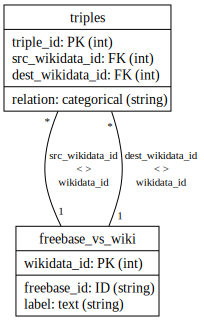

In [38]:
graph.visualize();

In [39]:
graph['triples']['relation'].stype

categorical

In [40]:
model = rfm.KumoRFM(graph)

Output()

In [ ]:
# PREDICT triples.relation
# Couldn't pick a unique triples.relation for each freebase_vs_wiki. row 1, column 8: Encountered an error, we have found multiple 'relation' values in the 'triples' table for a single 'freebase_vs_wiki'. To fix this, you have two options:
## 1. Aggregate the values: If your 'triples' table has a 'created at' column, use an aggregation function to reduce them to one value. 
##   For example: PREDICT LAST(triples.relation, 0, 30, days).
## 2. Rewrite your query: If you are writing a static node prediction predictive query, make sure that you 
##   either use the same table to define your target and entity, or you have a foreign key from the entity pointing to the target table, not the other way around.


# FOR triples.src_wikidata_id=7413907
# Invalid entity. row 2, column 4: Entity 'triples.src_wikidata_id' is not a primary key. 
# The column used in 'FOR EACH' has to be a primary key.

# FOR 

In [ ]:
kumo.init(api_key=KUMO_API_KEY)

In [41]:
query = """PREDICT triples.relation
FOR freebase_vs_wiki.wikidata_id=7413907"""

df = model.predict(query)
display(df)

ValueError: Failed to parse query 'PREDICT triples.relation
FOR freebase_vs_wiki.wikidata_id=7413907'. Errors:
Couldn't pick a unique triples.relation for each freebase_vs_wiki. row 1, column 8: Encountered an error, we have found multiple 'relation' values in the 'triples' table for a single 'freebase_vs_wiki'. To fix this, you have two options:
1. Aggregate the values: If your 'triples' table has a 'created at' column, use an aggregation function to reduce them to one value. For example: PREDICT LAST(triples.relation, 0, 30, days).
2. Rewrite your query: If you are writing a static node prediction predictive query, make sure that you either use the same table to define your target and entity, or you have a foreign key from the entity pointing to the target table, not the other way around.

pquery_relations_for_entity = kumo.PredictiveQuery(
	graph=graph,
	query=query
)

pquery_relations_for_entity.validate()

In [42]:
graph._to_api_graph_definition()

GraphDefinition(tables={'triples': TableDefinition(cols=[Column(name='triple_id', stype=ID, dtype=int, timestamp_format=None), Column(name='src_wikidata_id', stype=ID, dtype=int, timestamp_format=None), Column(name='relation', stype=categorical, dtype=string, timestamp_format=None), Column(name='dest_wikidata_id', stype=ID, dtype=int, timestamp_format=None)], source_table=UnavailableSourceTable(table='triples', data_source_type=UNAVAILABLE), pkey='triple_id', time_col=None, end_time_col=None), 'freebase_vs_wiki': TableDefinition(cols=[Column(name='freebase_id', stype=ID, dtype=string, timestamp_format=None), Column(name='label', stype=text, dtype=string, timestamp_format=None), Column(name='wikidata_id', stype=ID, dtype=int, timestamp_format=None)], source_table=UnavailableSourceTable(table='freebase_vs_wiki', data_source_type=UNAVAILABLE), pkey='wikidata_id', time_col=None, end_time_col=None)}, col_groups=[ColumnKeyGroup(columns=(ColumnKey(table_name='freebase_vs_wiki', col_name='wiki